# Credit Card Anomaly Detection Using Unsupervised Techniques

Anomaly detection is the identification of data points, items, observations or events that do not conform to the expected pattern of a given group. These anomalies occur very infrequently but may signify a large and significant threat such as cyber intrusions or fraud. Anomaly detection is heavily used in behavioral analysis and other forms of analysis in order to aid in learning about the detection, identification and prediction of the occurrence of these anomalies.

##### What to expect?

This notebook will extensively cover 8 steps to achieve fraud detection, so sit back and i will try to be as clear as possible.

    1. Algorithm/Model Selection
    2. Data identification and exploration
    3. Data visualization and presentation
    4. Dataset pre-processing
    5. Dataset splitting and training 
    6. Resampling of data in the dataset
    7. Dataset outlier detection using various algorithms (IForest, LOF, COPOD, and DAN)
        7b. Visualization of the outliers and inliers (concentrating more on the outliers)
        7c. Evaluation and metrics
    8. Predicting fraudulent transactions with ‘unseen data’

Let's Go!!!

### 1. Algorithm/Model Selection

Anomaly detection can be approached in many ways depending on the nature of data and circumstances. Following is a classification of some of those techniques (https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/)

A system for anomaly detection should NOT be a supervised ML algorithm as it will (maybe) learn only anomalies it has seen during training. The true magic lies in being able to identify an anomaly never seen before...

Some of the algorithms we will test out are;
- Auto Encoders
- Local Outlier Factor LOF
- COPOD
- Isolation Forest

### 2. Data identification and exploration

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Due to confidentiality issues, features from V1 to V28 have been transformed using PCA , the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.

##### Import all modules

In [53]:
# Data Processing and Visualiation
import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec

# Modeling
from scipy.stats import multivariate_normal
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from pyod.models.copod import COPOD

from imblearn.combine import SMOTETomek, _smote_tomek
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# Others
import os
import time
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

In [70]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
print(df.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


As we can see the data has 284,807 observations(rows) and 31 features(columns). Let's break that down a bit

In [ ]:
# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.to_csv("dataset.csv")

In [3]:
data = df.copy()
normal_data = data.loc[data["Class"] == 0] 
fraud_data = data.loc[data["Class"] == 1]

print("data size -> ", data.shape) # Size of entire data
print("normal_data -> ", normal_data.shape) # Size of genuine transactions in the entire dataset
print("fraud_data -> ", fraud_data.shape) # Size of fraud transactions in the entire dataset
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset') # Percentage of genuine
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset') # Percentage of fraud
print("_"*120) # Just for fun

data.head()

data size ->  (284807, 31)
normal_data ->  (284315, 31)
fraud_data ->  (492, 31)
No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
________________________________________________________________________________________________________________________


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# A check for Null values!
df.isnull().sum().max()

0

<b>Note</b>: Notice how imbalanced our original dataset is! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

### 3. Data visualization and presentation

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

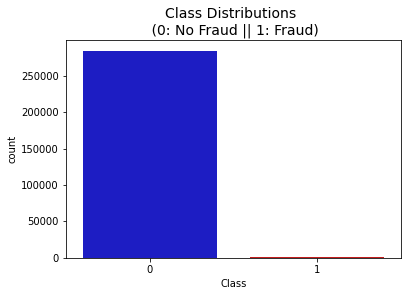

In [5]:
# Count plot of fraud transactions vs genuine transactions on the entire dataset
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Only <b>Time</b> and <b>Amount</b> have not been transformed with PCA. Time contains the seconds elapsed between each transaction and the first transaction in the dataset. Lets transofrm this feature into hours to get a better understanding.

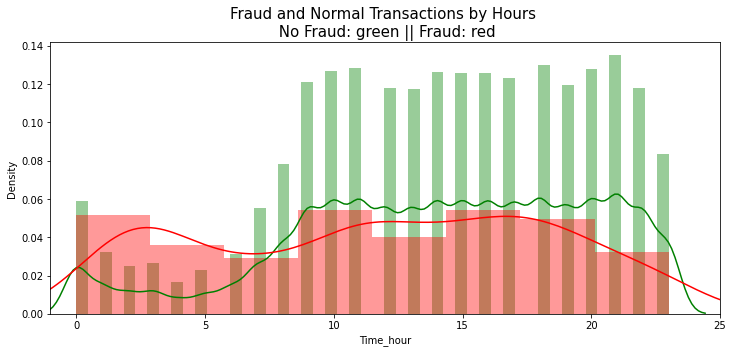

In [6]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int) # Transform time from seconds to hours

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours \n No Fraud: green || Fraud: red', fontsize=15)
plt.xlim([-1,25])
plt.show()

From the chart above the hour of day cut across 24 hours have some impact on number or fraud cases.


### 4. Dataset pre-processing

##### Feature transformation
Lets transform the remaining features in this case 'Time' and 'Amount' using PCA
PCA will be used to linearly reduce the dimension of these features from high-dimensional space to a lower-dimensional space

In [7]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

# V29 and V30 will be the new Time and Amount respectively
df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

df.drop(['Time','Time_hour', 'Amount'], axis=1, inplace=True)

df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'V29', 'V30'],
      dtype='object')

Now lets have a view at distribution of features

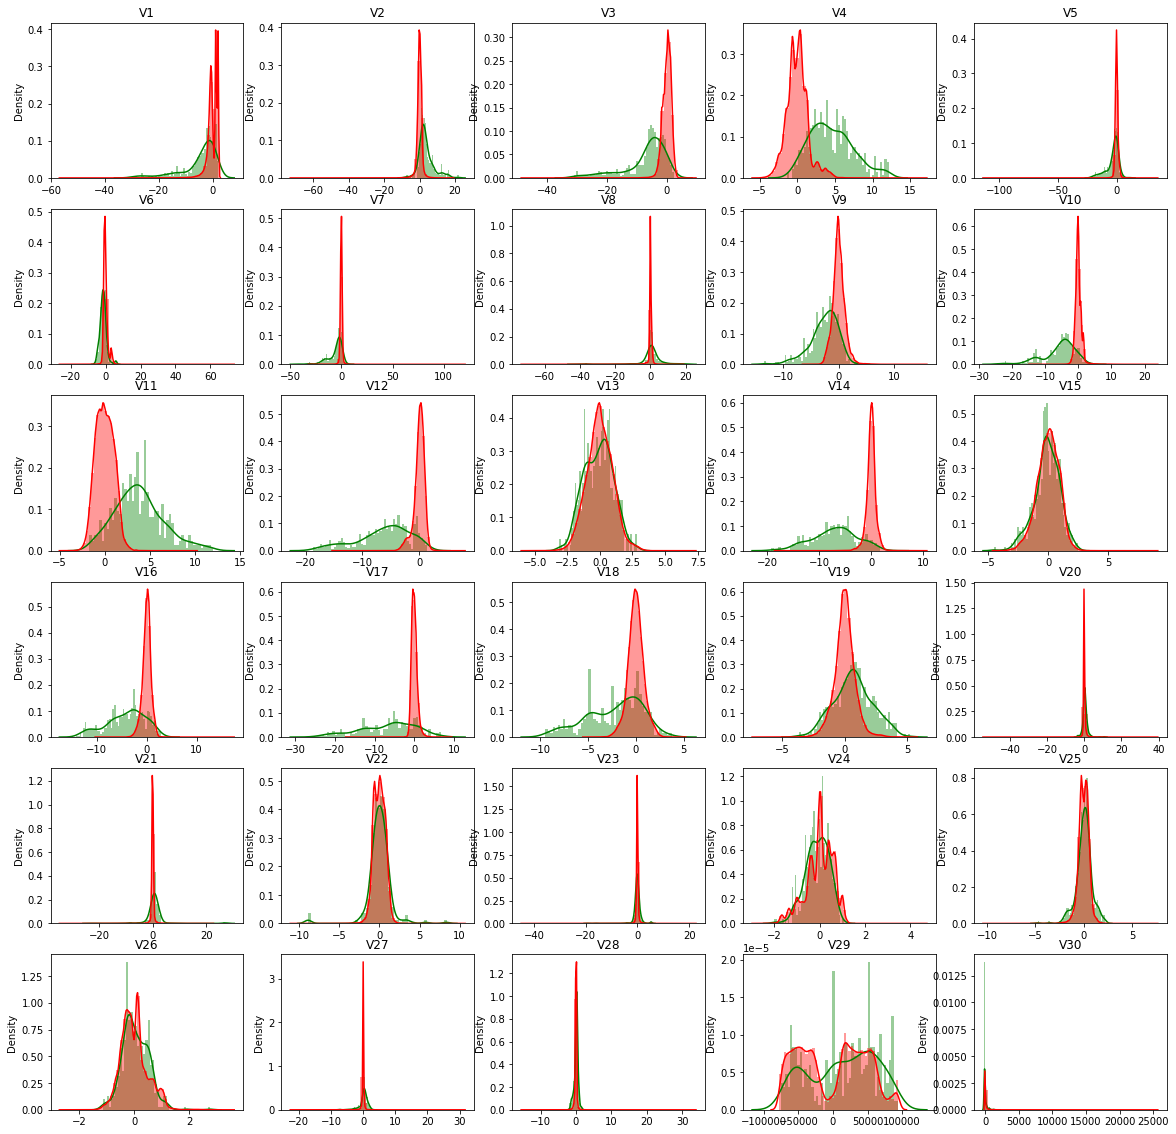

In [8]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(6, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins = 50, color='g')
    sns.distplot(df[df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

As we can see that data distribution of normal and fraud cases of some features like V13, V15, V22, V23, V25 and 26 are overlapping and they seem same. Such features are not good at differentiating between normal and fraud transactions.

##### Feature Selection using Z-test
Lets move to do some hypothesis testing to find statistically significant features. We will be performing Z-test with valid transactions as our population.

So the case is we have to find if the values of fraud transactions are significantly different from normal transaction or not for all features. The level of significance is 0.01 and its a two tailed test.

<b>Scenario:</b>
- Valid transactions as our population
- Fraud transactions as sample
- Two tailed Z-test
- Level of significance 0.01
- Corresponding critical value is 2.58

<b>Hypothesis:</b>
- H0: There is no difference (insignificant)
- H1: There is a difference (significant)

<b>Formula for z-score:</b>
                                            
                                            Zscore=(x¯−μ)/S.E

In [9]:
def ztest(feature):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

In [10]:
columns= df.drop('Class', axis=1).columns
normal= df[df.Class==0]
fraud= df[df.Class==1]
sample_size=len(fraud)
significant_features=[]
critical_value=2.58

for i in columns:
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

V1  is statistically significant
V2  is statistically significant
V3  is statistically significant
V4  is statistically significant
V5  is statistically significant
V6  is statistically significant
V7  is statistically significant
V9  is statistically significant
V10  is statistically significant
V11  is statistically significant
V12  is statistically significant
V14  is statistically significant
V16  is statistically significant
V17  is statistically significant
V18  is statistically significant
V19  is statistically significant
V20  is statistically significant
V21  is statistically significant
V24  is statistically significant
V27  is statistically significant
V28  is statistically significant
V29  is statistically significant
V30  is statistically significant


As we have already seen from distribution plots that distribution of normal and fraud data of V13, V15, V22, V23, V25 and 26 features is almost same, now, its proven through hypothesis testing. We will eliminate these features from our dataset as they don't contribute at all.

In [11]:
# Add the class feature back to the significant features only and reassign the dataframe to hold only significant
significant_features.append('Class')
df = df[significant_features]

df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V27', 'V28',
       'V29', 'V30', 'Class'],
      dtype='object')


##### Scaling and Distributing
Now we will first scale the columns comprise of Time and Amount. Time and amount should be scaled as the other columns.


In [12]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V18,V19,V20,V21,V24,V27,V28,V29,V30,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,...,0.025791,0.403993,0.251412,-0.018307,0.066928,0.133558,-0.021053,94813.862847,55.978567,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,...,-0.183361,-0.145783,-0.069083,-0.225775,-0.339846,-0.008983,0.014724,94813.854647,-90.951433,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,...,-0.121359,-2.261857,0.524980,0.247998,-0.689281,-0.055353,-0.059752,94812.875630,285.018623,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,...,1.965775,-1.232622,-0.208038,-0.108300,-1.175575,0.062723,0.061458,94812.861389,29.858623,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,...,-0.038195,0.803487,0.408542,-0.009431,0.141267,0.219422,0.215153,94811.858403,-23.651321,0


In [13]:
# Since most of our data has already been scaled
# we should scale the columns that are left to scale - Time(V29) Amount(V30))

std_scaler = StandardScaler()

df['scaled_time'] = std_scaler.fit_transform(df['V29'].values.reshape(-1,1))
df['scaled_amount'] = std_scaler.fit_transform(df['V30'].values.reshape(-1,1))

df.drop(['V29','V30'], axis=1, inplace=True)

In [14]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(21, 'V29', scaled_time)
df.insert(22, 'V30', scaled_amount)

#  Time (V29) and Amount(30) are Scaled!

df.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V18,V19,V20,V21,V24,V27,V28,V29,V30,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,...,0.025791,0.403993,0.251412,-0.018307,0.066928,0.133558,-0.021053,1.996583,0.223820,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,...,-0.183361,-0.145783,-0.069083,-0.225775,-0.339846,-0.008983,0.014724,1.996583,-0.363652,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,...,-0.121359,-2.261857,0.524980,0.247998,-0.689281,-0.055353,-0.059752,1.996562,1.139593,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,...,1.965775,-1.232622,-0.208038,-0.108300,-1.175575,0.062723,0.061458,1.996562,0.119384,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,...,-0.038195,0.803487,0.408542,-0.009431,0.141267,0.219422,0.215153,1.996541,-0.094565,0


### 5. Dataset splitting

##### Splitting the Data (Original DataFrame)
In a real-world application, classification modeling often encountered with an imbalanced dataset problem as we have seen in our case, where the number of non-fraud class is much bigger than the fraud class, thus making the model unable to learn from fraud class well.

To achieve this we either to oversample the fraud class or undersample the non-fraud class.

Before proceeding with the Sampling technique we have to separate the orginal dataframe. Why? for testing purposes, remember although we are splitting the data when implementing UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [15]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1) # The entire dataset features except the class column
y = df['Class'] # Only the class column

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)

# Train is 70% of our entire dataset, While test is 30%
# X_train is all features except class in the Train split
# y_train is only the class in the Train split
# X_test is all features except class in the Test split
# y_test is only the class in the Test split

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
X_train -  (199364, 23)
y_train -  (199364,)
X_test -  (85443, 23)
y_test -  (85443,)


### 6. Resampling of data in the dataset

In a real-world application, classification modeling often encountered with an imbalanced dataset problem as we have seen in our case, where the number of non-fraud class is much bigger than the fraud class, thus making the model unable to learn from fraud class well.
To achieve this we either to oversample the fraud class or undersample the non-fraud class.

##### SMOTE Links

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

In [67]:
# Oversampling only on train
"""We have to resample only the train set (X_train and y_train) Because we would use this data to build model.
    But when it's time to test this model we would like to test it on original data that has neither been used before
    or resampled, so we get the best accuracy."""

print('Train dataset shape %s' % Counter(y_train)) # Count all fraud and genuine transacations from y_train which is Class feature
random_state = 42

# Smote will collect all the fraud transactions and learn to create more
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
# By the time it is done it will create more fraud transctions so they are the same number with genuine transactions
print('Resampled Train dataset shape %s' % Counter(y_res))

X_train_smote = X_res
y_train_smote = y_res

# So now we have an additional set of fraud transactions synthetically created and balance to genuine transactions
# While our test set was never touched
print("X_train - ",X_train_smote.shape)
print("y_train - ",y_train_smote.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Train dataset shape Counter({0: 199008, 1: 356})
Resampled Train dataset shape Counter({0: 199008, 1: 199008})
X_train -  (398016, 23)
y_train -  (398016,)
X_test -  (85443, 23)
y_test -  (85443,)


In [69]:
smote

SMOTE(random_state=42)

In [17]:
print(y_train_smote.to_frame().value_counts())

Class
0        199008
1        199008
dtype: int64


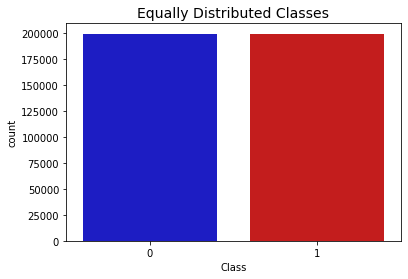

In [18]:
# There are now an equal number of fraud and genuine transactions on our train set
m_data = y_train_smote.to_frame()
sns.countplot('Class', data=m_data, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

##### ADASYN

ADASYN is a generalized form of the SMOTE algorithm. This algorithm also aims to oversample the minority class by generating synthetic instances for it. But the difference here is it considers the density distribution, ri which decides the no. of synthetic instances generated for samples which difficult to learn. Due to this, it helps in adaptively changing the decision boundaries based on the samples difficult to learn. 

The same steps from above are repeated only uses Adasyn

In [19]:
# Oversampling only on train

print('Train dataset shape %s' % Counter(y_train))
random_state = 42

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

print('Resampled Train dataset shape %s' % Counter(y_res))

X_train_adasyn = X_res
y_train_adasyn = y_res

# With Adasyn you'd notice how they are not exactly equal fraud samples against
print("X_train - ",X_train_adasyn.shape)
print("y_train - ",y_train_adasyn.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

Train dataset shape Counter({0: 199008, 1: 356})
Resampled Train dataset shape Counter({1: 199032, 0: 199008})
X_train -  (398040, 23)
y_train -  (398040,)
X_test -  (85443, 23)
y_test -  (85443,)


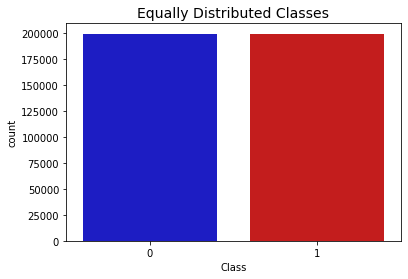

In [20]:
m_data = y_train_adasyn.to_frame()
sns.countplot('Class', data=m_data, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

##### Correlation Matrices

Understanding our data requires correlation matrices in its most basic form. We want to discover if there are characteristics that have a significant impact on whether a particular transaction is fraud. To determine which attributes have a strong positive or negative correlation with fraud transactions, it is crucial that we employ the appropriate dataframe (subsample).

In [21]:
data = df.copy() # Copy of our original dataset
all_cols = list(data)[:] # All of our columns
XcopyALL = data[all_cols]
# Combine our resampled trainsets (X and y) back into one datset and re-assign to now be our main data
data = np.concatenate((X_train_smote, y_train_smote.to_frame()), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

# amount of fraud classes 199008 rows from our resampled 
fraud_df = data.loc[data['Class'] == 1] # Collect all fraud transactions
non_fraud_df = data.loc[data['Class'] == 0] # Collect all genuine transactions

# Finally add fraud transactions and genuine transactions into one dataset
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

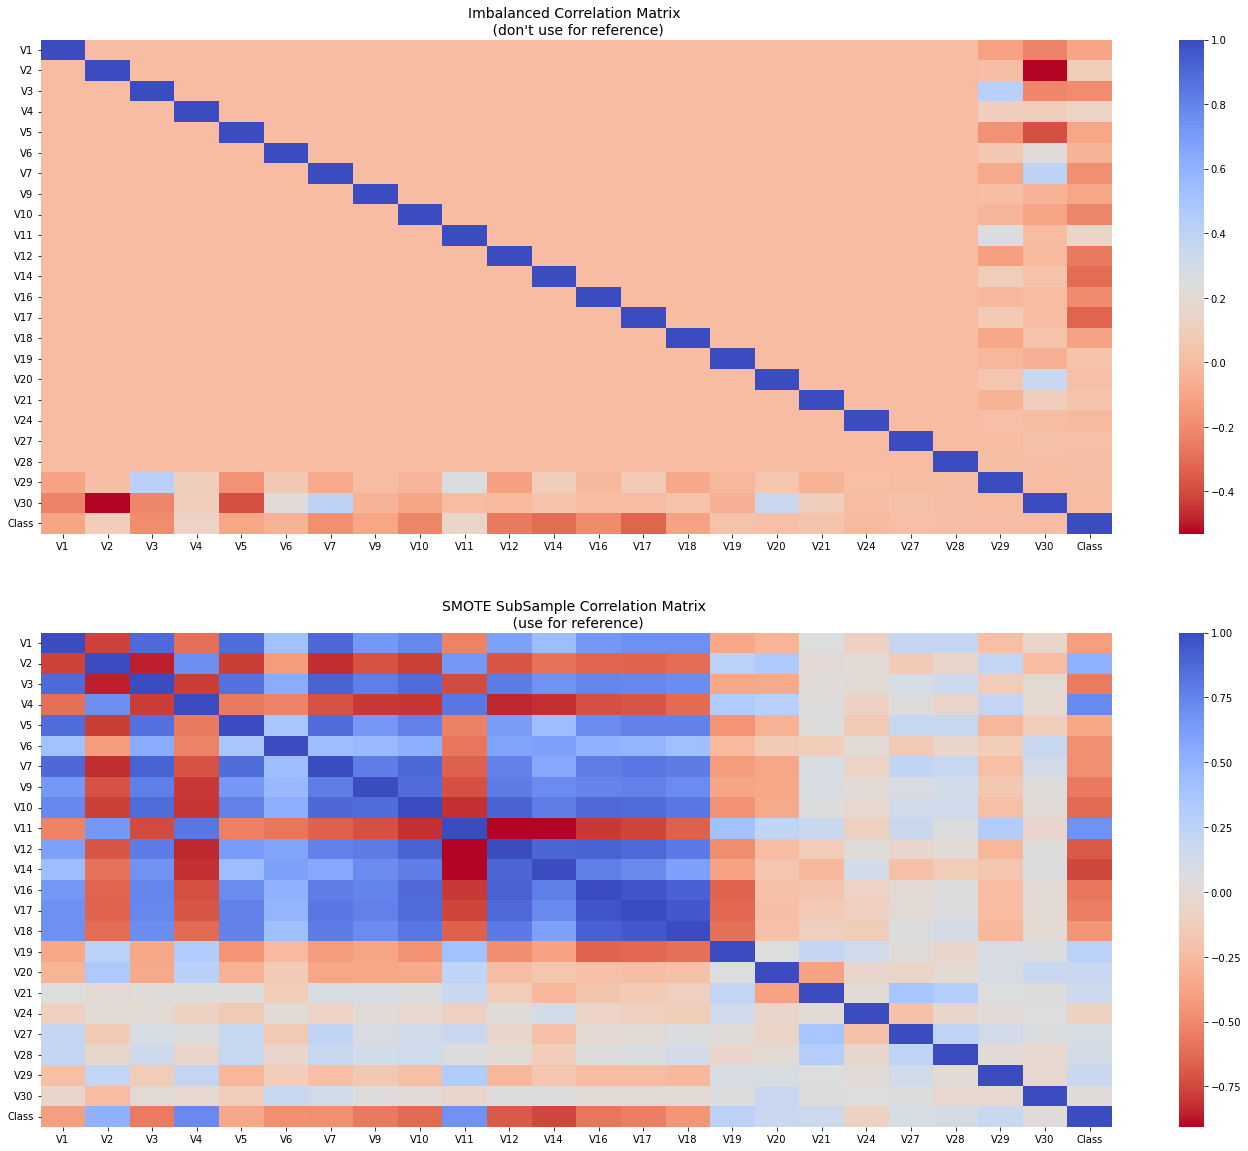

In [22]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire Orginal DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Entire resampled Dataframe
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SMOTE SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

### 7. Dataset outlier detection using various algorithms (IForest, LOF, COPOD, and DAN)

##### Isolation Forest

In an Isolation Forest, randomly sub-sampled data is processed in a tree structure (Similar to random forests) based on randomly selected features. The samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations.

In [23]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    """This function would display our confusion matrix"""
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [24]:

inliers = data[data.Class==0] # The train data for all non-fraud cases -> 199008 samples
ins = inliers.drop(['Class'], axis=1) # Remove the class column

outliers = data[data.Class==1] # The train data for all fraud cases -> 199008 samples
outs = outliers.drop(['Class'], axis=1) # Remove the class column

ins.shape, outs.shape # print the sizes

((199008, 23), (199008, 23))

In [25]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [26]:
state = 42

ISF = IsolationForest(random_state=state) # Create our isolation forest with a random state of 42
ISF.fit(ins) # Fit it on only inlers, non-frauds

# use the learnt to predict on inliers and outliers seperately, different sets of results are predicted
normal_isf = ISF.predict(ins) 
fraud_isf = ISF.predict(outs)

# Check for the accuracy by comparing for what was being predicted with the actual values
in_accuracy_isf=normal_accuracy(normal_isf)
out_accuracy_isf=fraud_accuracy(fraud_isf)
print("Accuracy in Detecting Normal Cases:", in_accuracy_isf)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_isf)

Accuracy in Detecting Normal Cases: 0.9572
Accuracy in Detecting Fraud Cases: 0.85


Because it is an anomaly detection algorithm and not a regular supervised classification algorithm. Predicted values return 1 and -1 as opposed to 0 and 1 which we have in our class distribution.
Where:
- 1's are Inliers
- -1's are outliers

In [27]:
# replace 1 with 0 and -1 with 1
np.place(normal_isf, normal_isf == 1, 0)
np.place(normal_isf, normal_isf == -1, 1)

np.place(fraud_isf, fraud_isf == 1, 0)
np.place(fraud_isf, fraud_isf == -1, 1)

In [28]:
predicted = np.r_[normal_isf, fraud_isf] # Combine normal and fraud predictions into one predicted
# Create a actual test set, where all the first 199008 are zeros because all the first 199008 samples in the
# predicted are meant to be normal which is zero, and the next 199008 are ones
actual = np.concatenate([np.zeros(199008), np.ones(199008)]) 

In [29]:
print('-------------------SMOTE-------------------')
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(predicted , actual))) 
print('ROC : {0:0.5f}'.format(metrics.roc_auc_score(actual , predicted)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(actual , predicted)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(actual , predicted)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(actual , predicted)))

-------------------SMOTE-------------------
Accuracy :0.90358
ROC : 0.90358
Precision : 0.95204
Recall : 0.84998
F1 : 0.89812


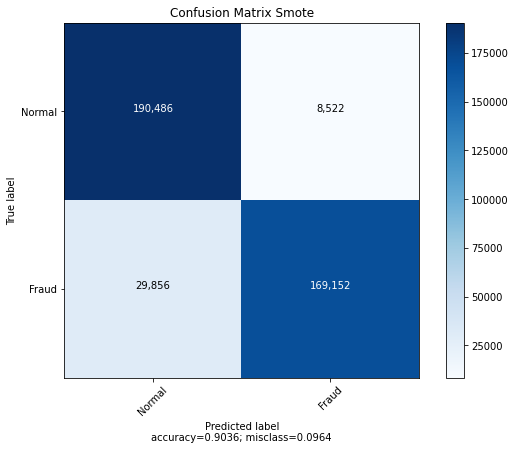

In [30]:
CM_smote = confusion_matrix(actual, predicted)
tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()

plot_confusion_matrix(CM_smote, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix Smote")

##### Local Outlier Factor (LOF)

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.
It's similar to Isolation forest in training steps

Local Outlier Factor (LOF) is a score that tells how likely a certain data point is an outlier/anomaly using the density of data points.


In [31]:
# Train with SMOTE data

LOF = LocalOutlierFactor(novelty=True) # Create our isolation forest with a random state of 42
LOF.fit(ins)

normal_lof = LOF.predict(ins)
fraud_lof = LOF.predict(outs)

in_accuracy_lof=normal_accuracy(normal_lof)
out_accuracy_lof=fraud_accuracy(fraud_lof)
print("Accuracy in Detecting Normal Cases:", in_accuracy_lof)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_lof)

Accuracy in Detecting Normal Cases: 0.9614
Accuracy in Detecting Fraud Cases: 0.2297


In [32]:
# replace 1 with 0 and -1 with 1
np.place(normal_lof, normal_lof == 1, 0)
np.place(normal_lof, normal_lof == -1, 1)

np.place(fraud_lof, fraud_lof == 1, 0)
np.place(fraud_lof, fraud_lof == -1, 1)

In [33]:
predicted = np.r_[normal_lof, fraud_lof] # Combine normal and fraud predictions into one predicted
# Create a actual test set, where all the first 199008 are zeros because all the first 199008 samples in the
# predicted are meant to be normal which is zero, and the next 199008 are ones
actual = np.concatenate([np.zeros(199008), np.ones(199008)])

In [34]:
print('-------------------SMOTE-------------------')
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(predicted , actual))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(actual , predicted)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(actual , predicted)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(actual , predicted)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(actual , predicted)))

-------------------SMOTE-------------------
Accuracy :0.59555
AUC : 0.59555
Precision : 0.85613
Recall : 0.22970
F1 : 0.36222


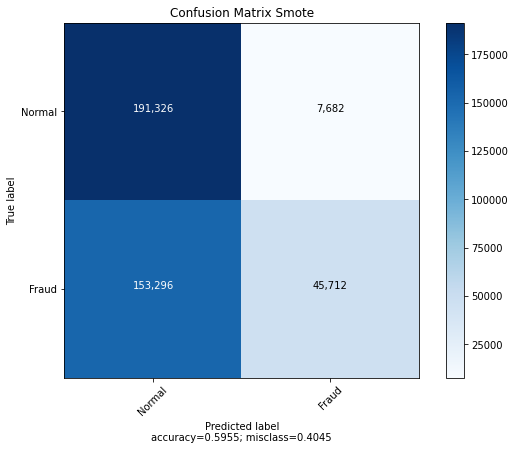

In [35]:
CM_smote = confusion_matrix(actual, predicted)
tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()

plot_confusion_matrix(CM_smote, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix Smote")

##### Copula-Based Outlier Detection (COPOD)

Copula-Based Outlier Detection — COPOD — is a new algorithm for anomaly detection. It has been implemented in the PyOD python package.

It has several key features that make it stand out from competing algorithms:
- Deterministic
- No hyperparameters! (This is important because is difficult to tune hyperparameters for outlier detection tasks because the true labels are rare, unknown, or difficult to obtain)
- Top-performance on benchmark anomaly detection datasets
- Interpretable and easy to visualize anomalies
- Fast and computationally efficient
- Scales to high-dimensional datasets

The model can return a raw outlier score, but also a decision outcome.

A challenge with anomaly detection algorithms, is that they are producing scores, which you then have to interpret. Determning what is an anomaly and what is not an anomaly, can often depend on the context. SO, it is quite likely you will need to use the raw decision score, and then adapt it to your domain.

In [36]:
# SMOTE

clf_name = 'COPOD'
clf = COPOD()
clf.fit(X_train_smote)
test_scores = clf.decision_function(X_test)
predicted = clf.predict(X_test)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, precision @ rank n:{prn}')

COPOD ROC:0.9085, precision @ rank n:0.2941


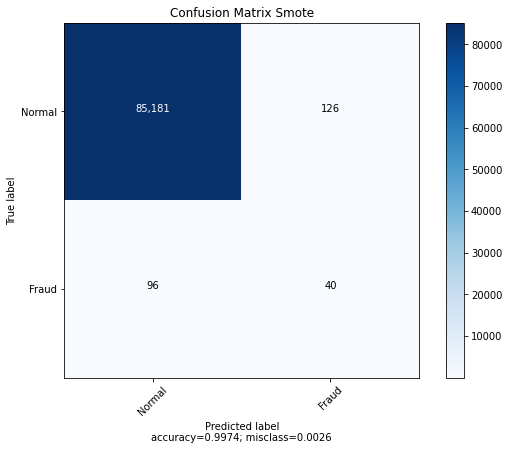

In [37]:
CM_smote = confusion_matrix(y_test, predicted)
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()

plot_confusion_matrix(CM_smote, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix Smote")

In [38]:
# ADASYN

clf_name = 'COPOD'
clf = COPOD()
clf.fit(X_train_adasyn)

test_scores = clf.decision_function(X_test) # outlier scores

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, precision @ rank n:{prn}')

COPOD ROC:0.9417, precision @ rank n:0.3235


#### Deep Autoencoder (DAN)

Autoencoder is an unsupervised neural network model that uses reconstruction error to detect anomalies or outliers. The reconstruction error is the difference between the reconstructed data and the input data.

- The idea is to use the Reconstruction Error as the limit to separate between Normal (low reconstruction error) and Fraud anomalies (high reconstruction errors)
- Reconstruction error is the MSE between the input X_train and the output of the autoencoder which has the same dimensions as X_train.
- Not to be confused with the error between a prediction and the true label

The autoencoder model for anomaly detection has six steps. The first three steps are for model training, and the last three steps are for model prediction.

- <b>Step 1</b> is the encoder step. The essential information is extracted by a neural network model in this step.
- <b>Step 2</b> is the decoder step. In this step, the model reconstructs the data using the extracted information.
- <b>Step 3</b>: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.
- <b>Step 4</b>: Make predictions on a dataset that includes outliers.
- <b>Step 5</b>: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.
- <b>Step 6</b>: Identify the data points with a difference higher than the threshold to be outliers or anomalies.

##### ADASYN

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training

In [39]:
input_dim = X_train_adasyn.shape[1] # Input dimension is the length of columns in our dataset (23)
encoding_dim = 14

In [40]:
# Keras Auto Encoder model

input_layer = Input(shape=(input_dim, )) # Input layer of our neural network

# The 2nd layer is our first encoding layer that uses a "tanh" activation funtion and an activity regulizer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
# The 3rd layer is our second encoding layer it breaks down the input from the layer before it and activates
# using a "relu" function
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

# Then our 4th layer is our decoder it decodes the input from the encoder using "tanh" activator function
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
# The 5th layer is our last layer that decodes input from the decoder using our "relu" activator function
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# This whole process will create a model file for us to use on our data training
autoencoder.summary()

2022-08-18 15:10:50.554803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-18 15:10:50.577238: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 15:10:50.602445: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (david-oden-pc): /proc/driver/nvidia/version does not exist


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 14)                336       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 23)                184       
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


Let's train our model for 13 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [41]:
nb_epoch = 13 # Retrain our model 13 times
batch_size = 32 # for batch in every retrain use 32 samples off the dataset

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train_adasyn, X_train_adasyn,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

2022-08-18 15:10:56.026266: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73239360 exceeds 10% of free system memory.
2022-08-18 15:10:56.150024: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73239360 exceeds 10% of free system memory.


Epoch 1/13
12439/12439 [==============================] - 55s 4ms/step - loss: 3.9807 - accuracy: 0.6226 - val_loss: 0.8732 - val_accuracy: 0.6081
Epoch 2/13
12439/12439 [==============================] - 48s 4ms/step - loss: 3.8075 - accuracy: 0.7215 - val_loss: 0.8395 - val_accuracy: 0.6411
Epoch 3/13
12439/12439 [==============================] - 51s 4ms/step - loss: 3.7832 - accuracy: 0.7452 - val_loss: 0.8179 - val_accuracy: 0.6596
Epoch 4/13
12439/12439 [==============================] - 50s 4ms/step - loss: 3.7719 - accuracy: 0.7622 - val_loss: 0.8103 - val_accuracy: 0.6704
Epoch 5/13
12439/12439 [==============================] - 54s 4ms/step - loss: 3.7669 - accuracy: 0.7718 - val_loss: 0.8068 - val_accuracy: 0.6719
Epoch 6/13
12439/12439 [==============================] - 55s 4ms/step - loss: 3.7646 - accuracy: 0.7745 - val_loss: 0.8047 - val_accuracy: 0.6786
Epoch 7/13
12439/12439 [==============================] - 49s 4ms/step - loss: 3.7633 - accuracy: 0.7750 - val_loss: 0

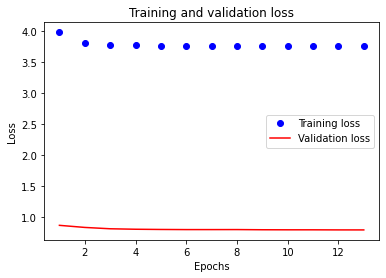

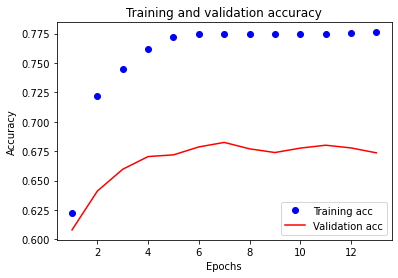

In [42]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, (len(history_dict['accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
# Load the best model saved above during training

autoencoder = load_model('model.h5')

In [44]:
# Reconstruction error on Train

# As Train has no Fraud
#y_train = np.zeros(X_train.shape[0])

predictions = autoencoder.predict(X_train_adasyn)
predictions.shape

mse = np.mean(np.power(X_train_adasyn - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train_adasyn})
print(error_df.shape[0], ' rows')
print('mean error of recon on TRAIN', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TRAIN', round(error_df.reconstruction_error.std(),2))

2022-08-18 15:23:00.514688: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73239360 exceeds 10% of free system memory.


12439/12439 [==============================] - 31s 2ms/step
398040  rows
mean error of recon on TRAIN 3.76
std error of recon on TRAIN 13.21


In [51]:
# Reconstruction error on Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')

error_df.describe()

2671/2671 [==============================] - 7s 3ms/step
85443  rows


,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.798525,0.001592
std,3.511590,0.039865
min,0.035491,0.000000
25%,0.268076,0.000000
50%,0.440036,0.000000
75%,0.706687,0.000000
max,266.790501,1.000000


In [46]:
# Reconstruction error on Fraud

pca_columns = list(data)[:-1] # all cols without Class
fraud_data = data.loc[data["Class"] == 1]
fraud_pca_data = fraud_data[pca_columns]

# As Fraud is all Fraud
y_Fraud = np.ones(fraud_pca_data.shape[0])
y_Fraud.shape

predictions = autoencoder.predict(fraud_pca_data)
predictions.shape

mse = np.mean(np.power(fraud_pca_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_Fraud})
print(error_df.shape[0], ' rows')
print('mean error of recon on FRAUD', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on FRAUD', round(error_df.reconstruction_error.std(),2))

6219/6219 [==============================] - 16s 3ms/step
199008  rows
mean error of recon on FRAUD 25.52
std error of recon on FRAUD 35.86


In [60]:
# Predictions on Normal vs Fraud on Test ... using the reconstruction error as the parameter to tweak for best F1

# Reconstruction error on Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('mean error of recon on TEST', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TEST', round(error_df.reconstruction_error.std(),2))

ReconError = 4.0

pred = [1 if e > ReconError else 0 for e in error_df.reconstruction_error.values]
len(pred)
#pred = (x <= eps)
accuracy = metrics.accuracy_score(pred, y_test)
print("Acurracy score on test", round(accuracy,4))

2671/2671 [==============================] - 8s 3ms/step
85443  rows
mean error of recon on TEST 0.8
std error of recon on TEST 3.51
Acurracy score on test 0.9827721404913217


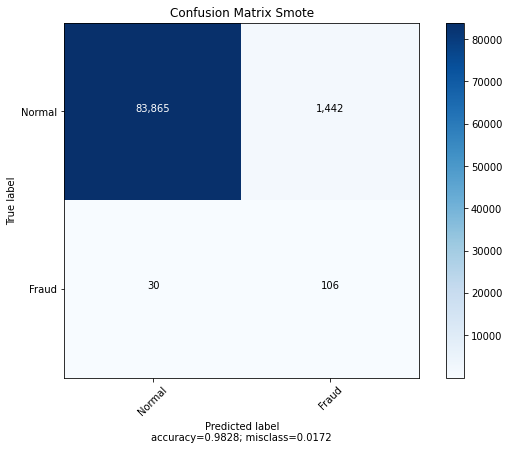

In [61]:
CM = confusion_matrix(y_test, pred)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix Smote")

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

Optimize the reconstruction error for best F1

In [62]:
minRE = 1
maxRE = 50
    
EpsF1 = []

for TryRE in range(minRE,maxRE):
    pred = [1 if e > TryRE else 0 for e in error_df.reconstruction_error.values]
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([TryRE, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['ReconError', 'F1'])
EpsF1df.head()

,ReconError,F1
0,1,0.0232
1,2,0.0666
2,3,0.0993
3,4,0.1259
4,5,0.1447


In [63]:
# Best Recon Error ... Max F1 on test

EpsF1df.loc[EpsF1df['F1'].idxmax()]

ReconError    38.0000
F1             0.3347
Name: 37, dtype: float64

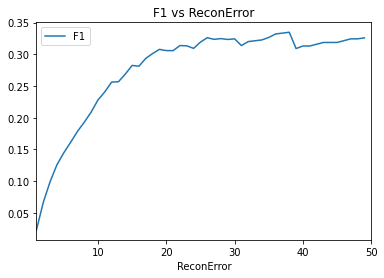

In [64]:
EpsF1df.plot.line("ReconError","F1")
plt.xlim(1, 50)
plt.title("F1 vs ReconError")
plt.show()

### Conclusion

We've created 4 analysed a credit card transactions, and even though we don't extensively understand all the features in the data and have to work with balancing a highly imbalanced dataset using 2 techniques SMOTE and ADASYN, we've been able to build 4 models to enable us detect outlier transactions;
- Isolation Forest (Best Model)
- Local outlier factor
- COPOD
- Auto-encoder

All our models have performed based on several hyperparameter tuning and data. We now can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

### Refrences

- 